<a href="https://colab.research.google.com/github/epigos/learning-pytorch/blob/master/notebooks/07_Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import defaultdict, deque
import math
import time
import copy
import itertools
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

Device name: Tesla T4


In [0]:
batch_size = 64

# Load data

In [4]:
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST('../dataset/', transform=transform_image, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Extracting ../dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../dataset/FashionMNIST/raw


Extracting ../dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../dataset/FashionMNIST/raw


Extracting ../dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../dataset/FashionMNIST/raw




Extracting ../dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../dataset/FashionMNIST/raw
Processing...
Done!


In [5]:
print(f"Number of training images: {len(dataset)}")
print(f"Size of each image: {dataset[0][0].size()}")

Number of training images: 60000
Size of each image: torch.Size([1, 28, 28])


## show some images

In [0]:
def imshow(img, ax=None, unnormalize=False, **kwargs):
    if not ax:
        _, ax = plt.subplots()

    if unnormalize:
        img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', **kwargs)
    plt.axis('off')
    plt.show()

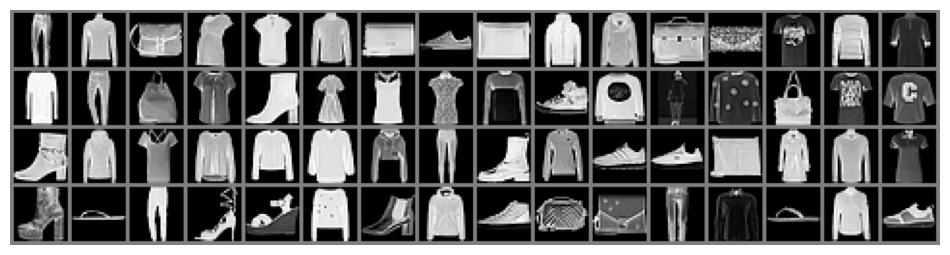

In [7]:
# get some random training images
data_iter = iter(data_loader)
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(batch_size/4))
imshow(grid, ax=ax, unnormalize=True)

# Create MLP VAE model

In [0]:
class Encoder(nn.Module):

    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()
        # linear layer
        self.fcl = nn.Sequential(
            nn.Linear(x_dim, h_dim1),
            nn.ReLU(),
            nn.Linear(h_dim1, h_dim2),
            nn.ReLU()
        )
        # mu layer
        self.mu = nn.Linear(h_dim2, z_dim)
        # log variance layer
        self.log_var = nn.Linear(h_dim2, z_dim)

    def forward(self, x):
        x = self.fcl(x)
        return self.mu(x), self.log_var(x)


class Decoder(nn.Module):

    def __init__(self, z_dim, h_dim2, h_dim1, x_dim):
        super().__init__()
        # linear layer
        self.fcl = nn.Sequential(
            nn.Linear(z_dim, h_dim2),
            nn.ReLU(),
            nn.Linear(h_dim2, h_dim1),
            nn.ReLU(),
            nn.Linear(h_dim1, x_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fcl(x)
        return x


class VAE(nn.Module):
    
    def __init__(self, input_size=28*28, latent_size=3):
        super().__init__()
        self.latent_size = latent_size
        self.input_size = input_size
        # encoder layer
        self.encoder = Encoder(input_size, 512, 256, latent_size)
        # decoder layer
        self.decoder = Decoder(latent_size, 256, 512, input_size)
        
    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var

    def inference(self, batch_size=1):
        """Function to make new image"""
        z = torch.randn([batch_size, self.latent_size], device=device)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


In [9]:
vae = VAE()
vae

VAE(
  (encoder): Encoder(
    (fcl): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=3, bias=True)
    (log_var): Linear(in_features=256, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (fcl): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [10]:
# test model
recons_x, my, log_var = vae(torch.rand(1, 1, 28 * 28))
recons_x.shape

torch.Size([1, 1, 784])

In [0]:
def to_image(x):
    """Convert model output to image"""
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def imshow_tensor(inputs, **kwargs):
    grid = torchvision.utils.make_grid(inputs, normalize=True, scale_each=True, nrow=int(batch_size/4))
    fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
    imshow(grid, ax=ax, **kwargs)
    plt.show()

In [0]:
reconstruction_function = nn.MSELoss(size_average=False)

def criterion(x, recons_x, mu, log_var):
    """
    x: original images
    recons_x: generated images
    mu: latent mean
    log_var: log variance
    """
    BCE = reconstruction_function(recons_x, x)  
    # KL loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_aspect = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_aspect).mul_(-0.5)
    # KL divergence
    return BCE + KLD


def train(model, data_loader, epochs=10, lr=1e-3, flatten=True):
    model = model.to(device)
    # define training functions
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    loss_history = deque(maxlen=epochs)
    vectors = []

    for epoch in range(1, epochs+1):        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            if flatten:
                inputs = inputs.view(inputs.size(0), -1)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch_x, mu, log_var = model(inputs)
            loss = criterion(inputs, recon_batch_x, mu, log_var)
            
            # store latent vectors
            temp = list(zip(labels.tolist(), mu.tolist()))
            for x in temp:
                vectors.append(x)

            # Backward pass
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item()

        batch_size = len(data_loader.dataset)
        epoch_loss = running_loss / batch_size
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, epoch_loss))
        print('-' * 60)
        loss_history.append(epoch_loss)
        # show output image
        if epoch % 5 == 0:
            imgs = to_image(recon_batch_x.cpu().data)
            imshow_tensor(imgs)
            print('-' * 60)
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model, vectors

## Train model

Epoch [1/10], Loss: 497.7171
------------------------------------------------------------
Epoch [2/10], Loss: 486.9732
------------------------------------------------------------
Epoch [3/10], Loss: 485.8881
------------------------------------------------------------
Epoch [4/10], Loss: 484.5308
------------------------------------------------------------
Epoch [5/10], Loss: 483.0739
------------------------------------------------------------


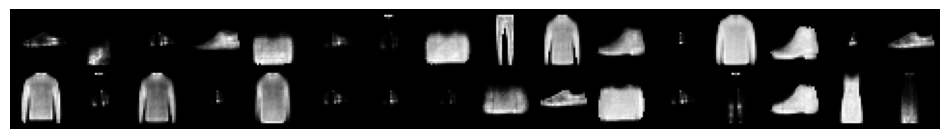

------------------------------------------------------------
Epoch [6/10], Loss: 482.3588
------------------------------------------------------------
Epoch [7/10], Loss: 481.8384
------------------------------------------------------------
Epoch [8/10], Loss: 481.3720
------------------------------------------------------------
Epoch [9/10], Loss: 481.1484
------------------------------------------------------------
Epoch [10/10], Loss: 480.8222
------------------------------------------------------------


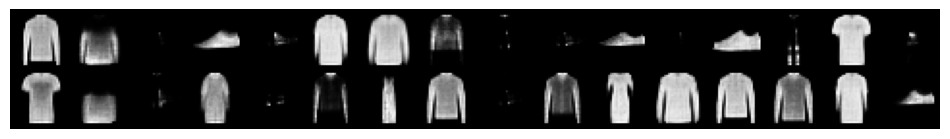

------------------------------------------------------------
Training complete in 3m 0s


In [13]:
vae = VAE()
m, latent_states = train(vae, data_loader)

The more epochs that pass, the clearer the images become as the model continues to learn.

## Visualize latent representations

Using Singular Value Decomposition, we perform Principal Component Analysis to visualise the two largest eigenvalues. Then we add the labels for each element and create a dataframe.


In [0]:
labels, z_vectors = list(zip(*latent_states))
z_vectors = torch.tensor(z_vectors)
U, S, V = torch.svd(torch.t(z_vectors))
C = torch.mm(z_vectors, U[:, :2]).tolist()
C = [x + [labels[i]] for i, x in enumerate(C)]

In [25]:
idx_to_class = {v:k for k,v in dataset.class_to_idx.items()}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [16]:
df = pd.DataFrame(C, columns=['x', 'y', 'label']) 
df.label = df.label.replace(idx_to_class)
df.head()

,x,y,label
0,-0.060093,-0.183798,Sandal
1,-0.040333,-0.059210,Pullover
2,0.040193,-0.031162,Ankle boot
3,0.011384,-0.078155,Sneaker
4,-0.020731,-0.093975,Coat


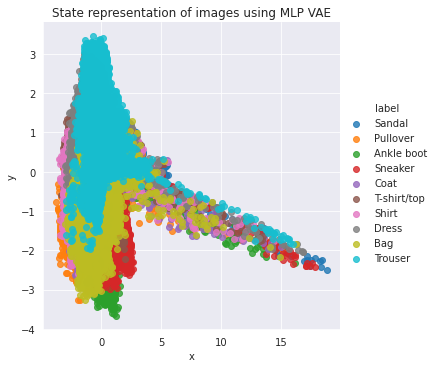

In [17]:
sns.lmplot(x="x", y="y", data=df, fit_reg=False, hue='label')
plt.title("State representation of images using MLP VAE")
plt.show()

## Generating images

In [0]:
# generate 64 samples
sample_size = 64
examples = vae.inference(sample_size)

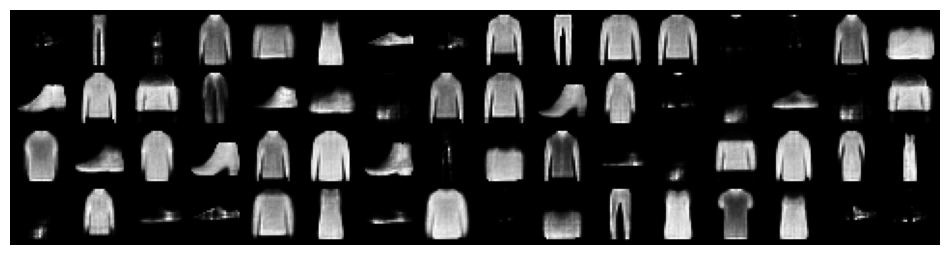

In [19]:
imgs = to_image(examples.cpu().detach())
imshow_tensor(imgs)

# Convolutional VAE

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super().__init__()
        self.channel = channel
        self.height = height
        self.width = width

    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)



class ConvEncoder(nn.Module):

    def __init__(self, n_channels, latent_size):
        super().__init__()
        self.n_channels = n_channels
        self.latent_size = latent_size
        # conv + linear layer
        self.conv_fcl = nn.Sequential(
            nn.Conv2d(n_channels, 16, (3,3), stride=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, (3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        # mu layer
        self.mu = nn.Linear(16, latent_size)
        # log variance layer
        self.log_var = nn.Linear(16, latent_size)

    def forward(self, x):
        x = self.conv_fcl(x)
        return self.mu(x), self.log_var(x)


class ConvDecoder(nn.Module):

    def __init__(self, n_channels, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.n_channels = n_channels
        # convolutional layer
        self.conv = nn.Sequential(
            nn.Linear(self.latent_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            Unflatten(8, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.latent_size, 16, (3,3), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, (5,5), stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class ConvVAE(nn.Module):
    
    def __init__(self, in_ch=1, latent_size=8):
        super().__init__()
        self.latent_size = latent_size
        self.in_ch = in_ch
        # encoder layer
        self.encoder = ConvEncoder(in_ch, latent_size)
        # decoder layer
        self.decoder = ConvDecoder(in_ch, latent_size)
        
    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var

    def inference(self, batch_size=1):
        """Function to make new image"""
        # generate random point
        z = torch.randn([batch_size, self.latent_size], device=device)
        # decode random point to form new image
        reconstructed_x = self.decoder(z)
        return reconstructed_x


In [14]:
conv_vae = ConvVAE().to(device)
conv_vae

ConvVAE(
  (encoder): ConvEncoder(
    (conv_fcl): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (6): ReLU()
      (7): Flatten()
      (8): Linear(in_features=32, out_features=16, bias=True)
      (9): ReLU()
    )
    (mu): Linear(in_features=16, out_features=8, bias=True)
    (log_var): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): ConvDecoder(
    (conv): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): ReLU()
      (4): Unflatten()
      (5): ReLU()
      (6): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    

In [15]:
# test model output
recon_x, mu, log_var = conv_vae(torch.rand(1, 1, 28, 28, device=device))
recon_x.shape

torch.Size([1, 1, 28, 28])

In [16]:
# test inference function
gen_img = conv_vae.inference(10)
gen_img.shape

torch.Size([10, 1, 28, 28])

## Train the model

Epoch [1/10], Loss: 229.6337
------------------------------------------------------------
Epoch [2/10], Loss: 120.0311
------------------------------------------------------------
Epoch [3/10], Loss: 108.4772
------------------------------------------------------------
Epoch [4/10], Loss: 103.2256
------------------------------------------------------------
Epoch [5/10], Loss: 99.2368
------------------------------------------------------------


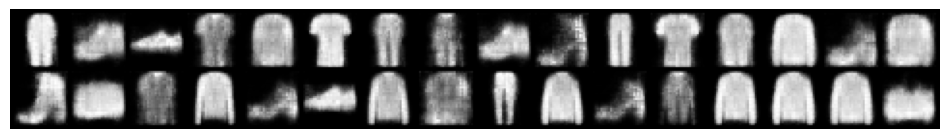

------------------------------------------------------------
Epoch [6/10], Loss: 96.4657
------------------------------------------------------------
Epoch [7/10], Loss: 94.4043
------------------------------------------------------------
Epoch [8/10], Loss: 92.7963
------------------------------------------------------------
Epoch [9/10], Loss: 91.6001
------------------------------------------------------------
Epoch [10/10], Loss: 90.6383
------------------------------------------------------------


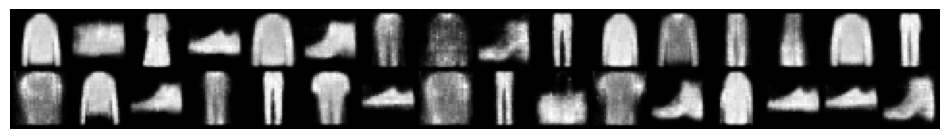

------------------------------------------------------------
Training complete in 2m 8s


In [17]:
conv_vae = ConvVAE()
m, latent_states = train(conv_vae, data_loader, flatten=False)

In [0]:
torch.save({
    "conv_vae": conv_vae.state_dict(),
    "idx_to_class": idx_to_class
}, "conv_vae.pth")

## Visualize latent representations

In [0]:
import pickle

In [0]:
with open("latent.pkl", 'wb') as f:
    pickle.dump(latent_states, f)

In [0]:
labels, z_vectors = list(zip(*latent_states))
z_vectors = torch.tensor(z_vectors)
U, S, V = torch.svd(torch.t(z_vectors))
C = torch.mm(z_vectors, U[:, :2]).tolist()
C = [x + [labels[i]] for i, x in enumerate(C)]

In [26]:
df = pd.DataFrame(C, columns=['x', 'y', 'label']) 
df.label = df.label.replace(idx_to_class)
df.head()

,x,y,label
0,0.389264,0.083009,Dress
1,0.365461,0.101787,Trouser
2,0.346111,0.037744,Bag
3,0.352836,0.070532,Bag
4,0.334516,0.067002,Dress


In [0]:
df.to_csv("latent_rep.csv", index=False)

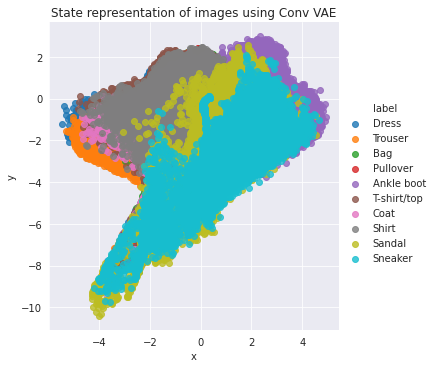

In [27]:
sns.lmplot(x="x", y="y", data=df, fit_reg=False, hue='label')
plt.title("State representation of images using Conv VAE")
plt.show()

## Generating images

In [0]:
# generate 64 samples
sample_size = 64
examples = conv_vae.inference(sample_size)

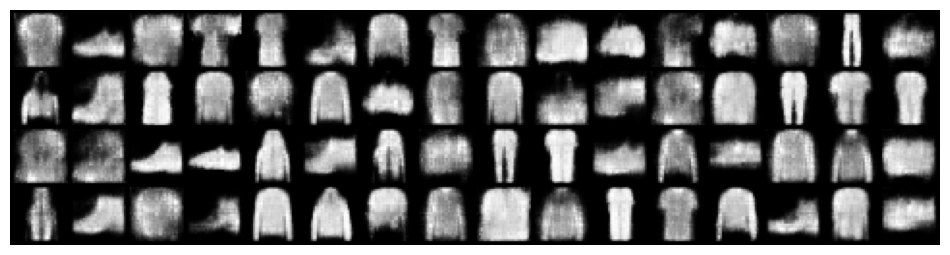

In [31]:
imgs = to_image(examples.cpu().detach())
imshow_tensor(imgs)